In [2]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [3]:
experiment_name = 'd01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [10]:
time_window = 25
time_step = 25
trial_bin_size = 20
n_splits = 30
group_dict_list = [OrderedDict([('ss1_vdis',[11]),('ss2',[20])]),OrderedDict([('ss1_dis',[12]),('ss2',[20])]),OrderedDict([('ss1_sim',[13]),('ss2',[20])])]
# group_dict_list = [OrderedDict([('ss1_vdis',[11]),('ss1_dis',[12])]),OrderedDict([('ss1_vdis',[11]),('ss1_sim',[13])])]
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict_list=group_dict_list)
clfr = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=2)

In [11]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub in range(exp.nsub):
    print(isub)

    xdata_all,ydata_all = exp.load_eeg(isub)
    
    for xdata,ydata in wrangl.pairwise(xdata_all,ydata_all):

        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [15]:
interp = eeg_decoder.Interpreter(clfr, subtitle='pairwise')
interp.save_results('pairwise')

In [6]:
a = np.mean(np.mean(interp.acc[:,:,interp.t>0],3),2)[:,0]
b = np.mean(np.mean(interp.acc[:,:,interp.t>0],3),2)[:,1]

In [7]:
import scipy.stats as sista

In [8]:
wrangl.labels

[['ss1_vdis', 'ss1_dis'], ['ss1_vdis', 'ss1_sim']]

1 (vdiff) vs 2 significant timepoints: [160 184 208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568
 592 616 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
1 (vdiff) vs 2 mean delay accuracy: 0.7359143518518518
1 (vdiff) vs 2 mean delay S.D.: 0.016814707900877676
1 (diff) vs 2 significant timepoints: [208 232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592 616
 640 664 688 712 736 760 784 808 832 856 880 904 928 952]
1 (diff) vs 2 mean delay accuracy: 0.694861111111111
1 (diff) vs 2 mean delay S.D.: 0.02540651360659261
1 (sim) vs 2 significant timepoints: [232 256 280 304 328 352 376 400 424 448 472 496 520 544 568 592 616 640
 664 688 712 736 760 784 808 832 856 880 904 928 952]
1 (sim) vs 2 mean delay accuracy: 0.6724768518518519
1 (sim) vs 2 mean delay S.D.: 0.024078291564333724


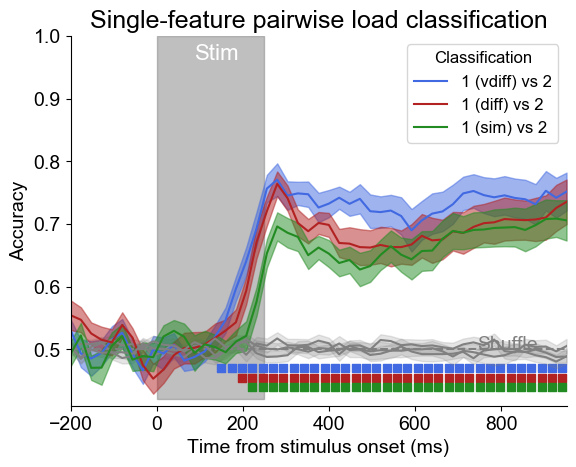

In [14]:
interp.plot_acc_subset(
    subset_list=['1 (vdiff) vs 2','1 (diff) vs 2','1 (sim) vs 2'],
    # subset_list=['1 (vdiff) vs 1 (diff)', '1 (vdiff) vs 1 (sim)'],
    ylim=[.41,1], 
    chance=.5, 
    sig_ys=[.47,.455,.44],
    # chance_text_xy=.225,
    significance_testing=True,
    title='Single-feature pairwise load classification',
    subtitle = '_single_feat_ss',
    savefig=False)